# TM index 1 denoising

This consists of one-off denoising requests, starting with the file named `TM_index1.txt`

# imports and globals

In [1]:
import pandas as pd
from skimpy import skim
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import pywt
# from skimage.restoration import denoise_nl_means, estimate_sigma
# from skimage import img_as_float
from skimage.restoration import denoise_bilateral
from skimage.restoration import denoise_tv_chambolle
from skimage.restoration import denoise_tv_bregman
import numpy as np
import os
import shutil
from scipy.ndimage import gaussian_filter
from tqdm import tqdm

from collections import defaultdict, Counter, deque
import h5py

import plotly.express as px
import plotly.graph_objects as go


In [2]:
# custom denoise function that applies piecewise total variation denoising and local optima preservation
# to the noisy data
# data is a pandas dataframe with columns lambda and signal

def custom_denoise(noisy_data, lambda_thresh=2.5e-6, init_weight=0.005, thresh=0.1, quiet=False):
    # first create a copy of noisy data
    denoised_data = noisy_data.copy(deep=True)
    # first split the data into 2 parts lambda < 2e-6 and lambda >= 2e-6
    lambda_thresh = lambda_thresh
    p1 = pd.DataFrame(noisy_data[noisy_data["lambda"] < lambda_thresh])
    p2 = pd.DataFrame(noisy_data[noisy_data["lambda"] >= lambda_thresh])

    # now we want to denoise the first part using the total variation denoising with weight 0.5
    weight = init_weight
    niter = 1
    p1_denoised = np.array(p1["signal"])
    for _ in range(niter):
        p1_denoised = denoise_tv_chambolle(p1_denoised, weight=weight)
    p1["smoothed_signal"] = p1_denoised

    # now we want to denoise the second part using the local preserver denoising
    # that we established in the earlier cells
    p2['increasing'] = [s1 < s2 for s1, s2 in zip(p2['signal'][:-1], p2['signal'][1:])] + [False]
    p2['diff'] = p2['signal'] - p2['signal'].shift(1)
    p2['diff_abs'] = p2['diff'].abs()

    direction_nums = []
    direction_num = 0
    for d1, d2 in zip(p2.increasing[:-1], p2.increasing[1:]):
        if d1 != d2:
            direction_num += 1
        direction_nums.append(direction_num)
    direction_nums.append(direction_num)
    p2["direction_num"] = direction_nums

    original_signals = np.array(p2.signal)

    localized_period = []
    period_diff = []
    p2_index = p2.index if quiet else tqdm(p2.index)
    for i, s, dn in zip(p2_index, original_signals, p2.direction_num):
        dnums_to_include = set()
        if dn > 1:
            dnums_to_include.add(dn - 2)
        if dn < direction_num - 1:
            dnums_to_include.add(dn + 2)
        df_subs = p2[p2.direction_num.isin(dnums_to_include)]
        min_diff = np.inf
        min_index = -1
        for j, s2 in zip(df_subs.index, df_subs.signal):
            if abs(s - s2) < min_diff:
                min_diff = abs(s - s2)
                min_index = j
        localized_period.append(min_index - i)
        period_diff.append(min_diff)
    p2["localized_period"] = localized_period
    p2["period_diff"] = period_diff

    diff = p2["period_diff"]
    diff_denoised = np.array(denoise_tv_chambolle(diff, weight=0.5))
    # lets say that the global minimum is at the location of the max of diff
    global_min = p2.loc[p2["period_diff"].idxmax()]
    win_size = 100
    global_min_index = diff.idxmax()
    local_minima = []
    #print(global_min)
    extracted_window = p2.loc[global_min_index - win_size:global_min_index + win_size]
    #print(extracted_window.shape)
    for d, dp, dn in zip(extracted_window["period_diff"][1:-1], extracted_window["period_diff"][:-2], extracted_window["period_diff"][2:]):
        if d > dp and d > dn and d != global_min["period_diff"]:
            local_minima.append(d)
    #thresh = round(max(local_minima) + 0.001, 3)
    thresh = thresh
    
    local_minima = []

    for ind,d,i in zip(p2.index, p2["period_diff"], range(len(p2))):
        if d > thresh and i > 0 and i < len(p2)-1 and p2["period_diff"].values[i-1] < d and p2["period_diff"].values[i+1] < d:
            local_minima.append(ind)
    if not quiet:
        print(len(local_minima))

    keep_dirs = set()
    for lm in local_minima:
        keep_dirs.add(p2.loc[lm].direction_num)
        if p2.loc[lm].direction_num > 0:
            keep_dirs.add(p2.loc[lm].direction_num - 1)

    p2["keep_dir"] = [dn in keep_dirs for dn in p2.direction_num]
    if not quiet:
        print(keep_dirs)
    if len(keep_dirs) == 0:
        # in this case we just apply the p1 denoising to the whole dataset and forget about preserving the local optima
        denoised_data["smoothed_signal"] = np.array(denoised_data["signal"])
        weight = 0.5
        niter = 5
        for _ in range(niter):
            denoised_data["smoothed_signal"] = denoise_tv_chambolle(denoised_data["smoothed_signal"], weight=weight)
        return denoised_data

    # now we split into 2 datasets, one with the keep_dir and one without
    p2_keep = pd.DataFrame(p2[p2.keep_dir])
    p2_no_keep = pd.DataFrame(p2[~p2.keep_dir])

    # now we smooth the signal for the no keep dataset with the total variation denoising
    # weight = 0.5 & 1_000 iterations
    weight = 0.5
    niter = 1000
    cur_buffer = []
    denoised_data = []
    for s,k in zip(p2.signal, p2.keep_dir):
        if k:
            if len(cur_buffer) > 0:
                cur_buffer = np.array(cur_buffer)
                # for _ in range(niter):
                #     cur_buffer = denoise_tv_chambolle(cur_buffer, weight=weight)
                # try a rolling window approach instead
                cur_buffer = pd.Series(cur_buffer).rolling(window=100, min_periods=1).median().values
                for _ in range(niter):
                    cur_buffer = denoise_tv_chambolle(cur_buffer, weight=weight)
                denoised_data.extend(cur_buffer)
                cur_buffer = []
        else:
            cur_buffer.append(s)
    if len(cur_buffer) > 0:
        cur_buffer = np.array(cur_buffer)
        for _ in range(niter):
            cur_buffer = denoise_tv_chambolle(cur_buffer, weight=weight)
        denoised_data.extend(cur_buffer)
    # len(orig_test_df_no_keep), len(denoised_data)
    p2_no_keep[f"smoothed_signal_tv_{weight}_{niter}"] = denoised_data

    # now we want to stitch the two datasets back together
    final_df_list = []

    # first we need to store the lambda, signal, and smoothed signal for the keep dataset into a deque sorted by lambda
    keep_deque = deque(sorted(zip(p2_keep["lambda"], p2_keep["signal"], p2_keep["increasing"])))
    # then we need to store the lambda, signal, and smoothed signal for the no keep dataset into a deque sorted by lambda
    no_keep_deque = deque(sorted(zip(p2_no_keep["lambda"], p2_no_keep["signal"], p2_no_keep[f'smoothed_signal_tv_{weight}_{niter}'], p2_no_keep["increasing"])))
    if not quiet:
        print(len(keep_deque), len(no_keep_deque))
    # now we iterate through the no keep dataset
    while len(no_keep_deque) > 0:
        # first check if the keep dataset is empty
        if len(keep_deque) > 0 and no_keep_deque[0][0] > keep_deque[0][0]:
            nl,ns,nd = keep_deque.popleft()
            nsd = nd
            if len(final_df_list) > 0:
                # now we check if the no keep dataset lambda is less than the keep dataset lambda
                pl,ps,pdi,pk,psd = final_df_list[-1]
                
                # note if we notice that the difference between the smoothed signal and the signal is 
                # greater than 0.01 and the previous point was from the no keep dataset then we want to replace the value with the previous value
                if abs(ns-psd) > 0.01:
                    if not pk:
                        if ns > psd:
                            nsd = psd + 0.01
                        else:
                            nsd = psd - 0.01
                    else:
                        # replace with the average of the two
                        nsd = (ns + psd) / 2
                else:
                    if nd:
                        nsd = max(ns,psd)
                    else:
                        nsd = min(ns,psd)
            final_df_list.append((nl,ns,nd,True,nsd))
        else:
            nl,ns,nsd,nd = no_keep_deque.popleft()
            # now we need to make sure smooth transition from the keep dataset to the no keep dataset
            if len(final_df_list) > 0:
                pl,ps,pdi,pk,psd = final_df_list[-1]
                if abs(nsd-psd) > 0.01:
                    if pk:
                        if nsd > psd:
                            nsd = psd + 0.01
                        else:
                            nsd = psd - 0.01
                    else:
                        # replace with the average of the two
                        nsd = (nsd + psd) / 2
            final_df_list.append((nl,ns,nd,False,nsd))
    #print(len(final_df_list), len(p2))

    local_smoothing_patched = pd.DataFrame(final_df_list, columns=["lambda","signal","increasing","local optima","smoothed_signal"])
    #print(noisy_data.shape,p1.shape,p2.shape,local_smoothing_patched.shape)
    result = pd.concat([p1[["lambda","signal","smoothed_signal"]], local_smoothing_patched], axis=0).reset_index(drop=True)

    # now we need to make sure there is no stitching artifact at the lambda_thresh
    # so we will just force a linear progression to the stitching_size points around the lambda_thresh
    stitching_sz = 20
    # first get the index closest to the lambda_thresh
    lambda_thresh_index = result["lambda"].sub(lambda_thresh).abs().idxmin()
    # now split into 3 parts, before, at, and after the lambda_thresh
    p1 = pd.DataFrame(result.loc[:lambda_thresh_index-(stitching_sz//2)])
    p2 = pd.DataFrame(result.loc[lambda_thresh_index-(stitching_sz//2):lambda_thresh_index+((stitching_sz+0.5)//2)])
    p3 = pd.DataFrame(result.loc[lambda_thresh_index+((stitching_sz+0.5)//2):])
    # now force the linear progression
    p2["smoothed_signal"] = np.linspace(p1["smoothed_signal"].values[-1], p3["smoothed_signal"].values[0], stitching_sz+1)
    # now stitch the 3 parts back together
    result = pd.concat([p1,p2,p3], axis=0).drop_duplicates(subset=["lambda"]).reset_index(drop=True)
    return result

# Load the data

In [3]:
# load the lambda values from the previous data file
prev_data = pd.read_csv("pb3000_h3000_data/pb3000_h3000_TE_1.3.txt")
prev_lambda = np.array(prev_data["lambda(m)"])

In [11]:
# load the TM index 1 data
tmi1 = pd.read_csv("TM_index1.txt")
tmi1.rename(columns={"lambda(m)": "lambda", " Y":"signal"}, inplace=True)
print(tmi1)

            lambda    signal
0     4.000000e-07  0.042318
1     4.009600e-07  0.041463
2     4.019200e-07  0.040629
3     4.028800e-07  0.039821
4     4.038400e-07  0.038991
...            ...       ...
9995  9.996160e-06  0.949073
9996  9.997120e-06  0.949225
9997  9.998080e-06  0.949380
9998  9.999040e-06  0.949540
9999  1.000000e-05  0.949703

[10000 rows x 2 columns]


In [14]:
tmi1_denoised = custom_denoise(tmi1, lambda_thresh=2.15e-6, quiet=False)

  0%|          | 0/8177 [00:00<?, ?it/s]

100%|██████████| 8177/8177 [00:05<00:00, 1609.06it/s]


13
{np.int64(139), np.int64(140), np.int64(268), np.int64(267), np.int64(23), np.int64(24), np.int64(55), np.int64(56), np.int64(185), np.int64(186), np.int64(189), np.int64(190), np.int64(62), np.int64(64), np.int64(63), np.int64(85), np.int64(86), np.int64(219), np.int64(220), np.int64(106), np.int64(107), np.int64(108), np.int64(123), np.int64(124)}
1856 6321


In [15]:
# create empty plotly figure
fig = go.Figure()
# fig = px.line(dn_test_data, x="lambda", y="signal", title="Noisy Data")
trace = go.Scatter(x=tmi1_denoised["lambda"], y=tmi1_denoised["signal"], mode='lines', name='Noisy Signal')
fig.add_trace(trace)
trace = go.Scatter(x=tmi1_denoised["lambda"], y=tmi1_denoised["smoothed_signal"], mode='lines', name='Denoised Signal')
fig.add_trace(trace)
fig.show()

In [17]:
tmi1_denoised[["lambda","signal","smoothed_signal"]].to_csv("TM_index1_denoised.csv", index=False)

In [55]:
all_data_txt_denoised = defaultdict(dict)

for rt in result_types:
    for ti in tqdm(times_indices):
        test_data = all_data[rt][ti]["TXT"].copy(deep=True)
        dn_test_data = custom_denoise(test_data,lambda_thresh=2.75e-6 if rt == "TM" else 3e-6, quiet=True)
        all_data_txt_denoised[rt][ti] = dn_test_data

100%|██████████| 201/201 [17:01<00:00,  5.08s/it]


# Assess any denoising outliers or introduced arifacts

One way to identify the denoising artifacts is to study the deviations from the denoised signal and the original signal from lambda >= 2e-6. Large devaitions indicate extremely large amounts of denoising, which could imply the creation of artifacts.

In [26]:
te_deviances_list = []
# first start with TE
rt = "TE"
for ti in tqdm(times_indices):
    df = all_data_txt_denoised[rt][ti]
    df = df[df["lambda"] >= 2e-6]
    datum = dict(df.loc[abs(df.signal-df.smoothed_signal).idxmax()])
    datum["abs_diff"] = max(df.signal-df.smoothed_signal)
    datum["times_index"] = ti
    datum["result_type"] = rt
    te_deviances_list.append(datum)
te_deviances_df = pd.DataFrame(te_deviances_list)

100%|██████████| 201/201 [00:00<00:00, 559.81it/s]


<Axes: xlabel='abs_diff', ylabel='Count'>

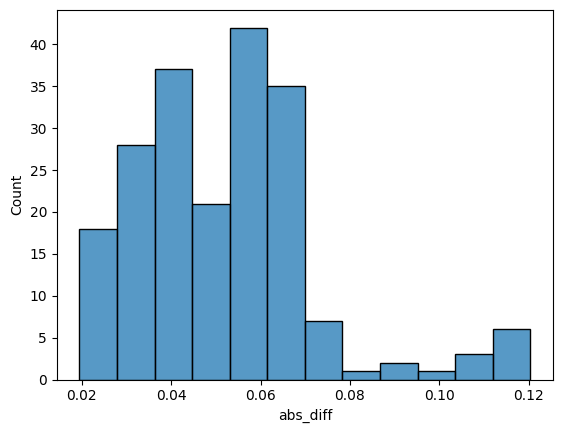

In [27]:
sns.histplot(data=te_deviances_df,x="abs_diff")

In [28]:
te_deviances_df[te_deviances_df.abs_diff >= 0.08].sort_values(by="abs_diff")

,lambda,signal,smoothed_signal,increasing,local optima,abs_diff,times_index,result_type
28,0.000004,0.715041,0.861530,True,False,0.081892,1328,TE
27,0.000004,0.710529,0.861946,True,False,0.091871,1327,TE
19,0.000004,0.686827,0.854113,True,False,0.094947,1319,TE
15,0.000005,0.814577,0.919976,True,False,0.099073,1315,TE
20,0.000004,0.681065,0.853506,True,False,0.106967,1320,TE
26,0.000004,0.707466,0.862226,True,False,0.107861,1326,TE
16,0.000004,0.940312,0.831976,False,False,0.108336,1316,TE
25,0.000004,0.708107,0.861729,True,False,0.112800,1325,TE
21,0.000004,0.686169,0.856233,True,False,0.114311,1321,TE
24,0.000004,0.710744,0.861762,True,False,0.115257,1324,TE


In [29]:
dn_test_data = all_data_txt_denoised["TE"][1328].copy(deep=True)
# create empty plotly figure
fig = go.Figure()
# fig = px.line(dn_test_data, x="lambda", y="signal", title="Noisy Data")
trace = go.Scatter(x=dn_test_data["lambda"], y=dn_test_data["signal"], mode='lines', name='Noisy Signal')
fig.add_trace(trace)
trace = go.Scatter(x=dn_test_data["lambda"], y=dn_test_data["smoothed_signal"], mode='lines', name='Denoised Signal')
fig.add_trace(trace)
fig.show()

It's not perfect, but i think good enough for a first pass ... 

In [30]:
tm_deviances_list = []
# first start with TM
rt = "TM"
for ti in tqdm(times_indices):
    df = all_data_txt_denoised[rt][ti]
    df = df[df["lambda"] >= 2e-6]
    datum = dict(df.loc[abs(df.signal-df.smoothed_signal).idxmax()])
    datum["abs_diff"] = max(df.signal-df.smoothed_signal)
    datum["times_index"] = ti
    datum["result_type"] = rt
    tm_deviances_list.append(datum)
tm_deviances_df = pd.DataFrame(tm_deviances_list)

100%|██████████| 201/201 [00:00<00:00, 616.18it/s]


<Axes: xlabel='abs_diff', ylabel='Count'>

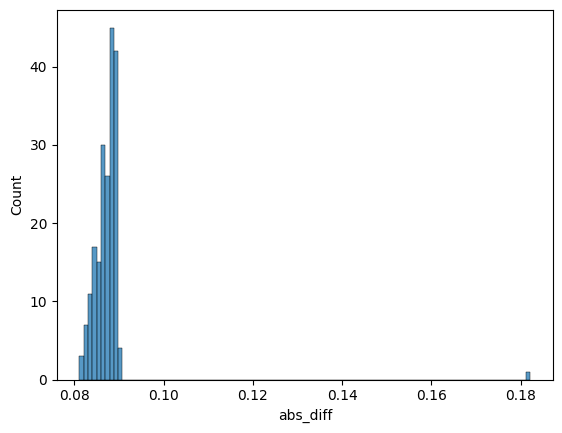

In [31]:
sns.histplot(data=tm_deviances_df,x="abs_diff")

In [32]:
tm_deviances_df[tm_deviances_df.abs_diff >= 0.08].sort_values(by="abs_diff")

,lambda,signal,smoothed_signal,increasing,local optima,abs_diff,times_index,result_type
200,0.000003,0.810541,0.897492,True,False,0.081120,1500,TM
199,0.000003,0.810249,0.897516,True,False,0.081882,1499,TM
198,0.000003,0.808010,0.897447,True,False,0.082057,1498,TM
196,0.000003,0.807298,0.897242,True,False,0.082157,1496,TM
194,0.000003,0.807198,0.896852,True,False,0.082169,1494,TM
...,...,...,...,...,...,...,...,...
86,0.000006,0.705390,0.848867,False,False,0.089792,1386,TM
128,0.000006,0.741136,0.865084,False,False,0.090027,1428,TM
111,0.000006,0.721937,0.857656,True,False,0.090054,1411,TM
110,0.000006,0.720713,0.857285,True,False,0.090154,1410,TM


In [33]:
dn_test_data = all_data_txt_denoised["TM"][1377].copy(deep=True)
# create empty plotly figure
fig = go.Figure()
# fig = px.line(dn_test_data, x="lambda", y="signal", title="Noisy Data")
trace = go.Scatter(x=dn_test_data["lambda"], y=dn_test_data["signal"], mode='lines', name='Noisy Signal')
fig.add_trace(trace)
trace = go.Scatter(x=dn_test_data["lambda"], y=dn_test_data["smoothed_signal"], mode='lines', name='Denoised Signal')
fig.add_trace(trace)
fig.show()

In [ ]:
test_data = all_data["TM"][1377]["TXT"].copy(deep=True)
dn_test_data = custom_denoise(test_data,lambda_thresh=2.75e-6, thresh=0.2)
# create empty plotly figure
fig = go.Figure()
# fig = px.line(dn_test_data, x="lambda", y="signal", title="Noisy Data")
trace = go.Scatter(x=dn_test_data["lambda"], y=dn_test_data["signal"], mode='lines', name='Noisy Signal')
fig.add_trace(trace)
trace = go.Scatter(x=dn_test_data["lambda"], y=dn_test_data["smoothed_signal"], mode='lines', name='Denoised Signal')
fig.add_trace(trace)
fig.show()

  0%|          | 0/7552 [00:00<?, ?it/s]

100%|██████████| 7552/7552 [00:02<00:00, 3287.57it/s]


8328 0.0003029999999999422 5880 0.00012099999999992672 0.00011099999999997223
8331 0.0009580000000000144 5883 7.80000000000225e-05 0.0006500000000000394
8333 0.0008590000000000542 5885 0.0006500000000000394 0.0008209999999999607
8336 0.0005589999999999762 5888 0.00022699999999997722 6.8000000000068e-05
8338 0.0006279999999999619 5890 6.8000000000068e-05 0.000528000000000084
8342 0.00041199999999996795 5894 0.00023700000000004273 0.00026500000000007073
8344 0.00035600000000002296 5896 0.00026500000000007073 0.0003549999999999942
8348 0.0009320000000000439 5900 0.0006869999999999932 0.00020699999999995722
8351 0.0002300000000000635 5903 0.00019799999999992046 0.00013099999999999223
8357 0.0008930000000000327 5909 0.0006909999999999972 0.0003630000000000022
8360 0.0032159999999999966 5912 0.0017359999999999598 0.0029649999999999954
8365 0.003964999999999996 5917 0.002263000000000015 0.0020379999999999843
8369 0.003960999999999992 5921 0.0019339999999999913 0.002438999999999969
8373 0.0036

So after assessing the signal at this location, the reason why the local preservation is failing is because this peak has a very gradual approach to its minima ...

It is rather annoying but to try to proceed with the project, I will just restrict the threshold to 2.75e-6 for the TM data and 3.0e-6 for the TE data.

Note: we might just want to discard samples like these where the denoising might be introducing some artifacts.

A future project could be to identify noise from 1D data using a context window and a neural network or classifier.

In [57]:
big_denoised_folder = "pb3000_h3000_data_denoised_craut_20250317"
if os.path.exists(big_denoised_folder):
    shutil.rmtree(big_denoised_folder)
os.makedirs(big_denoised_folder)
# save all the denoised data to a file
for rt in result_types:
    for ti in times_indices:
        all_data_txt_denoised[rt][ti].to_csv(f"{big_denoised_folder}/{rt}_denoised_{ti}.txt", sep="\t", index=False)

In [58]:
# compress the folder
shutil.make_archive(big_denoised_folder, 'zip', big_denoised_folder)

'c:\\Users\\craut\\Documents\\colorimetry_ML\\code\\p03_denoising\\pb3000_h3000_data_denoised_craut_20250317.zip'